# Machine Learning Engineer Nanodegree
## Model Evaluation & Validation
## Project 1: Predicting Boston Housing Prices

## Getting Started
In this project, you will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

Run the code cell below to load the Boston housing dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [12]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import visuals as vs # Supplementary code
from sklearn.cross_validation import ShuffleSplit

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration
In this first section of this project, you will make a cursory investigation about the Boston housing data and provide your observations. Familiarizing yourself with the data through an explorative process is a fundamental practice to help you better understand and justify your results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics
For your very first coding implementation, you will calculate descriptive statistics about the Boston housing prices. Since `numpy` has already been imported for you, use this library to perform the necessary calculations. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below, you will need to implement the following:
- Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
  - Store each calculation in their respective variable.

**Using Pandas (more efficient)**

In [18]:
# TODO: Minimum price of the data
minimum_price = prices.min()
# alternative 

# TODO: Maximum price of the data
maximum_price = prices.max()

# TODO: Mean price of the data
mean_price = prices.mean()

# TODO: Median price of the data
median_price = prices.median()

# TODO: Standard deviation of prices of the data
std_price = prices.std()

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,340.28


_Personal note: There's nothing to state what degree of freedom to use for standard deviation. Thus, I've used the default of ddof=1 since this is a sample from the population and we should not use ddof=0._

### Question 1 - Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

_Using your intuition, for each of the three features above, do you think that an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`? Justify your answer for each._  
**Hint:** Would you expect a home that has an `'RM'` value of 6 be worth more or less than a home that has an `'RM'` value of 7?

**Answer: **
1. RM
    - For a higher RM, one would expect to observe a higher MEDV. 
    - This is because more rooms would imply more space, thereby costing more, taking all other factors constant.
2. LSTAT
    - For a higher LSTAT, one would expect to observe a a lower MEDV.
    - The social milieux in an area dominated by "lower class" citizens may not be conducive for young children. It may also be relatively unsafe compared to an area dominated by "upper class" citizens. Hence an area with more "lower class" citizens would lower demand, hence lower prices.
3. PTRATIO
    - For a higher LSTAT, one would expect to observe a lower MEDV.
    - This is because there would be a lower teacher-to-student ratio resulting in less attention dedicated to each student that may impair their performance in school. Typically this is the scenario in public/state schools compared to private schools. And the prices of houses around public schools are generally lower than those around private schools. Hence one would expect a lower price given a high student-to-teacher ratio due to a lower demand for houses in such areas.
    
_Personal note: These are merely based on intuition. These statements will be validated in the subsequent parts of this project._

----

## Developing a Model
In this second section of the project, you will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, you will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 always fails to predict the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. *A model can be given a negative R<sup>2</sup> as well, which indicates that the model is no better than one that naively predicts the mean of the target variable.*

For the `performance_metric` function in the code cell below, you will need to implement the following:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [19]:
# TODO: Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Question 2 - Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |
*Would you consider this model to have successfully captured the variation of the target variable? Why or why not?* 

Run the code cell below to use the `performance_metric` function and calculate this model's coefficient of determination.

In [20]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

Model has a coefficient of determination, R^2, of 0.923.


**Answer:**
- R^2 = 92.3%
- This implies 92.3% of variation is explained by the target variable and it seems to be high.

### Implementation: Shuffle and Split Data
Your next implementation requires that you take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, you will need to implement the following:
- Use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to a value of your choice. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [27]:
# TODO: Import 'train_test_split'
from sklearn.cross_validation import train_test_split

# TODO: Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, train_size=0.8, random_state=10)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


**Extra check: Ritchie**

In [41]:
# Check if split is actually correct
# We can see it's roughly 80% train and 20% train
# So we can proceed!
print(features.shape[0])
print(float(X_train.shape[0]) / float(features.shape[0]))
print(float(X_test.shape[0]) / float(features.shape[0]))

489
0.799591002045
0.200408997955


### Question 3 - Training and Testing
*What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?*  
**Hint:** What could go wrong with not having a way to test your model?

**Answer: **
- Motivation: we need a way to choose between machine learning models. 
    - And our goal is to estimate likely performance of a model on out-of-sample data.
- Initial idea: we can train and test on the same data.
    - But, maximizing training accuracy rewards overly complex models that overfit the training data.
    - As you add more features, you can slowly reach a 100% accuracy but you are not able to generalize well. 
- Alternative idea: we can use train/test split.
    - We can split the dataset into two pieces so that the model can be trained and tested on different data.
    - Then, testing accuracy is a better estimate than training accuracy of out-of-sample performance.

**This is an extension beyond the scope of the train/test split question, highlighting the issue of high variance simply using train/test split without k-fold cross-validation.**
- But we've a big problem with train/test split.
    - It provides a high variance estimate since changing which observations happen to be in the testing set can significantly change testing accuracy.
    - Testing accuracy can change a lot depending on a which observation happen to be in the testing set.
    - Hence we've to use k-fold cross-validation to solve this problem.

----

## Analyzing Model Performance
In this third section of the project, you'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, you'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

Run the code cell below and use these graphs to answer the following question.

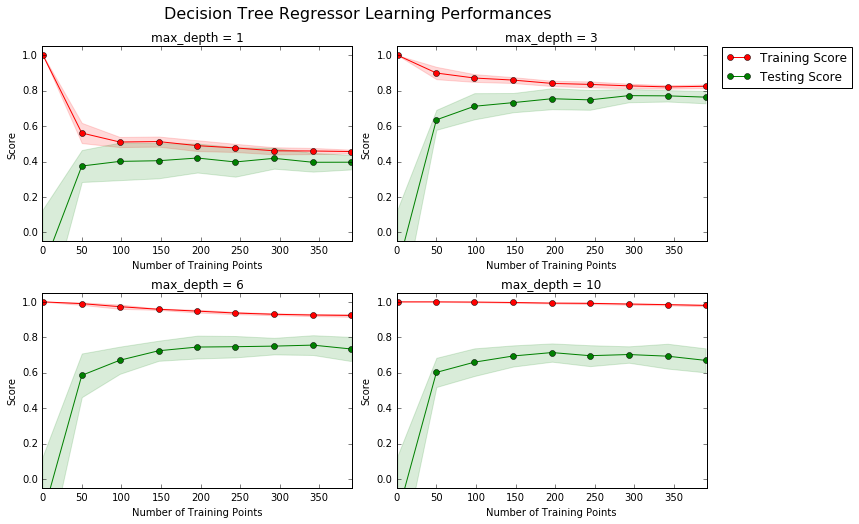

In [42]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Question 4 - Learning the Data
*Choose one of the graphs above and state the maximum depth for the model. What happens to the score of the training curve as more training points are added? What about the testing curve? Would having more training points benefit the model?*  
**Hint:** Are the learning curves converging to particular scores?

**Answer: **
- **max_depth = 1 (High Bias Scenario)**
    1. We can see how the testing score (green line) increases with the number of observations.
        - However, the testing score only increases to approximately 0.4, a low score.
        - This indicates how the model does not generalize well for new, unseen, data.   
    2. Moreover, the training score (red line) decreases with the number of observations. 
        - Also, the training score decreases to a very low score of approximately 0.4.
        - This indicates how the model does not seem to fit the data well. 
    3. Thus, we can say this model is facing a high bias problem. Consequently, having more training points would not benefit the model as the model is underfitting the dataset. Instead, one should increase the model complexity to better fit the dataset. 

**This is an extension explaining the rest of the depths for completeness. I have summarized everything instead of writing in full sentences.**
- **max_depth = 3 (Ideal Scenario)**
    1. Testing score (green line) increases with training points
        - Reaches ~0.8
        - High score
        - Generalize well
    2. Training score (red line) decreases slightly with training points
        - Reachers ~0.8
        - High score
        - Fit dataset well
    3. There seems to be no high bias or high variance problem
        - Model fits and generalizes well
        - Ideal
        - More training points should help it become an even more ideal model! 
- **max_depth = 10 (High Variance Scenario)**
    1. Testing score (green line) increases with training points
        - Reaches ~0.7
        - Not so high score
        - Does not generalize well
    2. Training score (red line) barely decreases with training points
        - At ~1.0
        - Almost perfect score
        - Overfitting dataset
    3. There seems to be a high variance problem
        - Overfitting
- **max_depth = 6 (Slightly High Variance Scenario)**
   1. Testing score (green line) increases with training points
        - Reaches ~0.75
        - Not so high score
        - Does not generalize well
   2. Training score (red line) decreases slightly with training points
        - At ~0.9
        - High score
        - Overfitting dataset
   3. There seems to be a high variance problem
        - Overfitting
        - More training points might help
        - This is getting close to the ideal scenario! 

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

Run the code cell below and use this graph to answer the following two questions.

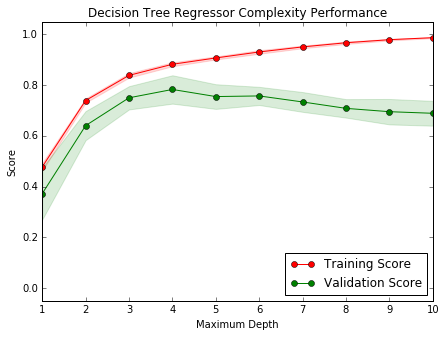

In [43]:
vs.ModelComplexity(X_train, y_train)

### Question 5 - Bias-Variance Tradeoff
*When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?*  
**Hint:** How do you know when a model is suffering from high bias or high variance?

**Answer: **
<br />**Identifying when a model is suffering from high bias or high variance.**
- It is easy to identify whether the model is suffering from a high bias or a high variance.
    - High variance models have a gap between the training and validation scores. 
        - This is because it is able to fit the model well but unable to generalize well resulting in a high training score but low validation score.
    - High bias models have have a small or no gap between the training and validations scores.
        - This is because it is unable to fit the model well and unable to generalize well resulting in both scores converging to a similar low score.
        
**Maximum depth of 1: High Bias**
- Both training and testing scores are low. 
- There is barely a gap between the training and testing scores.
- This indicates the model is not fitting the dataset well and not generalizing well hence the model is suffering from high bias.

**Maximum depth of 10: High Variance**
- Training score is high. Testing score is low
- There is a substantial gap between the training and testing scores.
- This indicates the model is fitting the dataset well but not generalizing well hence the model is suffering from high variance.

### Question 6 - Best-Guess Optimal Model
*Which maximum depth do you think results in a model that best generalizes to unseen data? What intuition lead you to this answer?*

**Answer: **
- The maximum depth of 4.
- The training score seems to plateau here, indicating the highest possible score for the model's ability to generalize to unseen data.
- Gap between the training score and testing score does not seem to be substantial too, indicating that the model may not be suffering from a high variance scenario.

-----

## Evaluating Model Performance
In this final section of the project, you will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Question 7 - Grid Search
*What is the grid search technique and how it can be applied to optimize a learning algorithm?*

**Answer: **
- In essence, the grid search technique allows one to define a grid of parameters that will be searched using K-fold cross-validation.
- One can then find the highest cross-validation accuracy that matches with the corresponding parameters that optimizes the learning algorithm.

### Question 8 - Cross-Validation
*What is the k-fold cross-validation training technique? What benefit does this technique provide for grid search when optimizing a model?*  
**Hint:** Much like the reasoning behind having a testing set, what could go wrong with using grid search without a cross-validated set?

**Answer: **
- K-fold cross-validation summary:
    - Dataset is split into K "folds" of equal size.
    - Each fold acts as the testing set 1 time, and acts as the training set K-1 times.
    - Average testing performance is used as the estimate of out-of-sample performance.
    - Also known as cross-validated performance.
- Benefits of k-fold cross-validation:
    - More reliable estimate of out-of-sample performance than train/test split.
    - Reduce the variance of a single trial of a train/test split.
- Hence, with the benefits of k-fold cross-validation, we're able to use the average testing accuracy as a benchmark to decide which is the most optimal set of parameters for the learning algorithm.
    - If we do not use a cross-validation set and we run grid-search, we would have different sets of optimal parameters due to the fact that without a cross-validation set, the estimate of out-of-sample performance would have a high variance.

### Implementation: Fitting a Model
Your final implementation requires that you bring everything together and train a model using the **decision tree algorithm**. To ensure that you are producing an optimized model, you will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

For the `fit_model` function in the code cell below, you will need to implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [53]:
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # ShuffleSplit works iteratively compared to KFOLD
    # It saves computation time when your dataset grows
    # X.shape[0] is the total number of elements
    # n_iter is the number of re-shuffling & splitting iterations.
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # TODO: Create a decision tree regressor object
    # Instantiate
    regressor = DecisionTreeRegressor()

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    dt_range = range(1, 11)
    params = dict(max_depth=dt_range)

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    # We initially created performance_metric using R2_score
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search object
    # You would realize we manually created each, including scoring_func using R^2
    grid = GridSearchCV(regressor, params, cv=cv_sets, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Question 9 - Optimal Model
_What maximum depth does the optimal model have? How does this result compare to your guess in **Question 6**?_  

Run the code block below to fit the decision tree regressor to the training data and produce an optimal model.

In [54]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 4 for the optimal model.


In [58]:
# Explanation of how we got the 'max_depth' param
# First we fit the model
# Then we use get_params() to get the optimal parameters
# As you can see here, it's a dictionary
reg = fit_model(X_train, y_train)
reg.get_params()

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [57]:
# We can access our value from reg.get_params(), a dictionary, using dict['key']
reg.get_params()['max_depth']

4

**Answer: **
- The optimal model has a maximum depth of 4.
- The max depth is the same as my guess in question 6. 

### Question 10 - Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |
*What price would you recommend each client sell his/her home at? Do these prices seem reasonable given the values for the respective features?*  
**Hint:** Use the statistics you calculated in the **Data Exploration** section to help justify your response.  

Run the code block below to have your optimized model make predictions for each client's home.

In [55]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

Predicted selling price for Client 1's home: $406,933.33
Predicted selling price for Client 2's home: $232,200.00
Predicted selling price for Client 3's home: $938,053.85


**Answer: **

**Prices to recommend**
- Client 1: 406,900
- Client 2: 232,200
- Client 3: 938,100

**Data Exploration Findings**
- Minimum price: $105,000.00

- Maximum price: $1,024,800.00

- Mean price: $454,342.94

- Median price $438,900.00

- Standard deviation of prices: $165,340.28

**Reasonableness**
- The prices are rounded up to the nearest hundred as the prices in the dataset are all rounded to the nearest hundred. 
- Compared to the data-exploration, it seems that the houses' prices from client 1 and client 2 are below the mean and median prices.
    - For client 2, it seems reasonable due to the high poverty level and student-to-teacher ratio.
    - For client 1, it also seems reasonable due to the average poverty level and student-to-teacher ratio.
- And the house's price from client 3 is way above the mean and median prices, nearing to the maximum price in the dataset.
    - This seems reasonable given the low poverty level and student-to-teacher ratio with a high number of rooms.

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with the data it's trained on.

In [61]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $424,935.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $73,357.39


### Question 11 - Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

**Answer: **
- Data collected from a rural city may not be applicable as the demographics would change and other features may be better able to fit the dataset instead of a model with features that was learned using urban data.
- The learning algorithm learned from a very old dataset that may not be relevant because demographics have changed a lot since 1978. 
- There are only 3 features currently, there are more features that can be included such as crime rates, nearby to city, public transport access and more.